In [1]:
import warnings

warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from plotnine import ggplot
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from plotnine import *
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix
from matplotlib import pyplot as plt
from sklearn import tree

In [2]:
games = pd.read_csv('./dataset/games.csv')
players = pd.read_csv('./dataset/players.csv')
plays = pd.read_csv('./dataset/plays.csv')
PFFScoutingData = pd.read_csv('./dataset/PFFScoutingData.csv')
#importing all csv

In [3]:
pred = [
 'quarter',
 'down',
 'yardsToGo',
 'possessionTeam',
 'kickerId',
 'yardlineNumber',
 'preSnapHomeScore',
 'preSnapVisitorScore',
 'homeTeamAbbr',
 'visitorTeamAbbr',
 'height',
 'weight']
# predictor to remove for no kicker or teams from pred
predkicker = ['homeTeamAbbr','visitorTeamAbbr','possessionTeam','kickerId']
outcome = 'specialTeamsResult'

In [4]:
def convertHeightinInches(x):
    x = x.split('-')
    x = np.array(x)
    x = x.astype(int)
    sum = x[0]*12+x[1]
    return sum
#def to reformat player height from feet and inches to inches to make it a continuous variable

In [5]:
#test
convertHeightinInches('5-6')

66

In [6]:
kickers = players.loc[players['Position'] == 'K']
kickers = kickers[kickers['height'].str.contains('-')]
#removing misformatted height data
kickers2 = kickers.copy()
kickers2['height'] = kickers['height'].apply(convertHeightinInches).copy()
kickers2 = kickers2.rename(columns = {'nflId':'kickerId'})
#reformatting players dataframe to merge kicker dataframe
kickers = kickers2

In [7]:
df1 = plays.merge(games,on='gameId',how='left')
df1 = df1.merge(kickers,on='kickerId',how='left')
df1 = df1.merge(PFFScoutingData, on='gameId', how = 'left')
df1.dropna(inplace = True, subset = pred)
#merging relevent dataframes

In [8]:
# df1.columns.values.tolist()

In [9]:
X = df1[pred]
y = df1[outcome]

In [10]:
X_extrapoint = X.loc[(df1['specialTeamsPlayType'] == 'Extra Point') | (df1['specialTeamsPlayType']  == 'Field Goal')]
y_extrapoint = y.loc[(df1['specialTeamsPlayType'] == 'Extra Point') | (df1['specialTeamsPlayType']  == 'Field Goal')]
X_punt = X.loc[(df1['specialTeamsPlayType'] == 'Kickoff') | (df1['specialTeamsPlayType']  == 'Punt')]
y_punt = y.loc[(df1['specialTeamsPlayType'] == 'Kickoff') | (df1['specialTeamsPlayType']  == 'Punt')]
# dividing extrapoints and punts

In [11]:
#no kicker or teams variable formatting
X_extrapoint_nokicker = X_extrapoint.copy().drop(predkicker, axis = 1)
X_extrapoint_nokicker
#y is same as X_extrapoint because we only removed predictors not rows

,quarter,down,yardsToGo,yardlineNumber,preSnapHomeScore,preSnapVisitorScore,height,weight
48,1,4,3,3,0,0,69.0,203.0
49,1,4,3,3,0,0,69.0,203.0
50,1,4,3,3,0,0,69.0,203.0
51,1,4,3,3,0,0,69.0,203.0
52,1,4,3,3,0,0,69.0,203.0
...,...,...,...,...,...,...,...,...
537080,4,0,0,15,22,26,74.0,205.0
537081,4,0,0,15,22,26,74.0,205.0
537082,4,0,0,15,22,26,74.0,205.0
537083,4,0,0,15,22,26,74.0,205.0


In [12]:
z = StandardScaler()
cont_vars = [
 'yardsToGo',
 'yardlineNumber',
 'preSnapHomeScore',
 'preSnapVisitorScore',
 'height',
 'weight']
ct = ColumnTransformer([('zscore', StandardScaler(), cont_vars)])
ct.fit_transform(X_extrapoint[cont_vars])
ct.fit_transform(X_punt[cont_vars])
ct.fit_transform(X_extrapoint_nokicker[cont_vars])
# z-scored continuous variables

array([[-0.06229869, -2.00058818, -1.31215752, -1.2545354 , -1.49491452,
         0.34328636],
       [-0.06229869, -2.00058818, -1.31215752, -1.2545354 , -1.49491452,
         0.34328636],
       [-0.06229869, -2.00058818, -1.31215752, -1.2545354 , -1.49491452,
         0.34328636],
       ...,
       [-0.67359703, -0.31998287,  0.85507544,  1.32071625,  0.92293829,
         0.46672024],
       [-0.67359703, -0.31998287,  0.85507544,  1.32071625,  0.92293829,
         0.46672024],
       [-0.67359703, -0.31998287,  0.85507544,  1.32071625,  0.92293829,
         0.46672024]])

In [13]:
disc_vars = [
 'quarter',
 'down',
 'possessionTeam',
 'kickerId',
 'homeTeamAbbr',
 'visitorTeamAbbr']
disc_vars_nokicker = [
 'quarter',
 'down']
# one hot encode discrete variables
X_extrapoint = pd.get_dummies(X_extrapoint,columns=disc_vars,drop_first=True)
X_extrapoint_nokicker = pd.get_dummies(X_extrapoint_nokicker,columns=disc_vars_nokicker,drop_first=True)
X_punt = pd.get_dummies(X_punt,columns=disc_vars,drop_first=True)
# dummy vars for outcome
y_extrapoint.loc[y_extrapoint == "Kick Attempt Good"] = 0
y_extrapoint.loc[y_extrapoint != 0] = 1
y_punt.loc[y_punt == "Kick Attempt Good"] = 0
y_punt.loc[y_punt != 0] = 1

In [14]:
# extra point
Xep_train, Xep_test, yep_train, yep_test = train_test_split(X_extrapoint, y_extrapoint, test_size = 0.2)
# punt
Xp_train, Xp_test, yp_train, yp_test = train_test_split(X_punt, X_punt, test_size = 0.2)
# extra point no teams
Xep_nokicker_train, Xep_nokicker_test, yep_nokicker_train, yep_nokicker_test = train_test_split(X_extrapoint_nokicker,y_extrapoint, test_size = 0.2)

<H2>Question 1</H2>

<H4>Here we are using LASSO to find which variables are most related to the success of a extra point kick or a punt kick.</H4>

In [15]:
lso = Lasso()
lso.fit(Xep_train, yep_train)
lasso_coef = lso.coef_
lasso_coef

array([ 0.,  0., -0., -0., -0.,  0.,  0., -0., -0.,  0.,  0.,  0.,  0.,
        0., -0., -0., -0.,  0., -0., -0.,  0.,  0.,  0., -0., -0., -0.,
       -0., -0., -0.,  0.,  0., -0., -0.,  0.,  0., -0., -0.,  0.,  0.,
        0., -0., -0., -0.,  0.,  0.,  0.,  0., -0.,  0., -0.,  0., -0.,
       -0., -0.,  0., -0.,  0., -0., -0., -0., -0., -0.,  0.,  0., -0.,
        0.,  0., -0.,  0., -0., -0.,  0., -0., -0., -0.,  0., -0.,  0.,
        0.,  0., -0., -0., -0., -0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,
        0.,  0., -0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0.,  0.,  0.,
       -0.,  0., -0.,  0.,  0., -0., -0., -0., -0.,  0., -0.,  0., -0.,
        0.,  0., -0., -0., -0.,  0., -0.,  0., -0.,  0., -0.,  0.,  0.,
        0., -0., -0.,  0.,  0., -0., -0.,  0.,  0., -0.,  0., -0.,  0.,
       -0.,  0., -0.,  0.,  0.,  0., -0.,  0., -0., -0., -0.,  0., -0.,
       -0.,  0.,  0., -0., -0., -0., -0.])

<p>Here I tried using LASSO to find what predictors are most effective to predict a successful extra point kick but it seems that there aren't any significant ones that LASSO thinks is useful. I think since LASSO aims to have the not very helpful coefficents of predictors equal 0 if it isnt really important to the correlation of the successful outcome, it thinks that none of the predictors are good enough predictors. This might be true but it isn't really helpful in our use case. I want to see roughly what the most useful predictors are and I don't need perfection for predicting if it is a successful kick or not. So I decided to switch from using LASSO to ridge regularization which does a similar thing to LASSO but instead of turning the unhelpful predictors' coefficents to 0, they are minimized as much as they can.

In [16]:
ridge = Ridge()
ridge.fit(Xep_train,yep_train)
ridge_ep_coef = ridge.coef_
ridge_ep_df = pd.DataFrame({'pred':ridge.feature_names_in_, 'coefs':ridge_ep_coef, 'absvals':np.abs(ridge_ep_coef)})
ridge_ep_df.sort_values(by=['absvals'], inplace=True, ascending = False)
ridge_ep_top5 = ridge_ep_df.head()
ridge_ep_top5

,pred,coefs,absvals
86,kickerId_46455.0,0.724186,0.724186
56,kickerId_38134.0,-0.420357,0.420357
33,possessionTeam_MIN,0.403182,0.403182
70,kickerId_41991.0,-0.328916,0.328916
58,kickerId_38691.0,-0.312960,0.312960


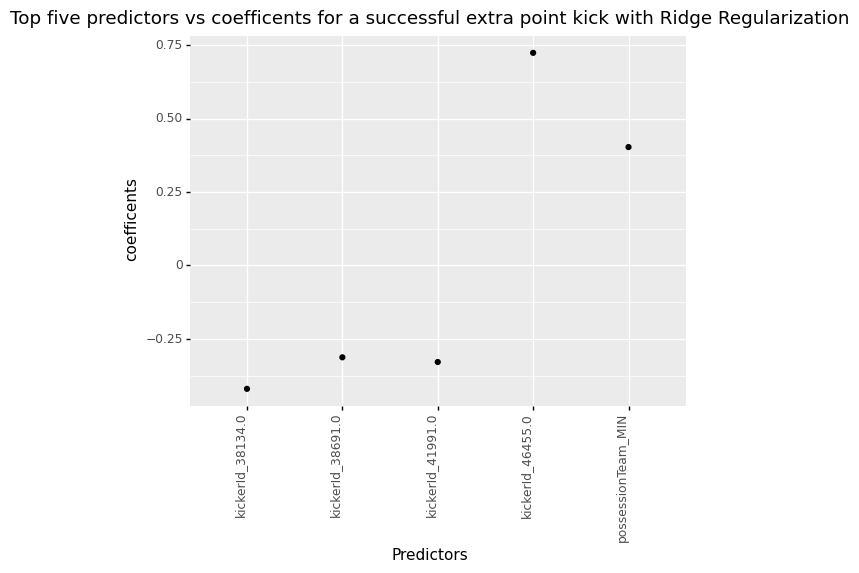

<ggplot: (402201372)>

In [17]:
(ggplot(ridge_ep_top5,aes(x='pred',y = 'coefs'))
 +geom_point()
 +theme(axis_text_x=element_text(rotation=90, hjust=1))
 +labs(title = "Top five predictors vs coefficents for a successful extra point kick with Ridge Regularization")
 +xlab('Predictors')
 +ylab('coefficents')
)

In [18]:
players.loc[players['nflId'] == 46455]

,nflId,height,weight,birthDate,collegeName,Position,displayName
2307,46455,6-3,210,1994-03-16,Marshall,K,Kaare Vedvik


The coefficents represent the predictor variable's correlation with a successful kick.
Here we can see the top 5 biggest coefficents or the 5 most correlated predictors to a succesful kick. I took the absolute value of the coefficents to find the biggest value coefficent but this graph shows the actual coefficents without the absolute value. Postitive coefficents represent a positive correlation with the predictors and the outcome. A negative one represents a negative correlation.

The coefficents with the 4 biggest absolute values were the kickers and 1 possession team. This means that the individual kickers have the most impact on the success of the kick which is pretty understandable. Kaare Vedvik is the most likely to score an extra point according to the data. Kicker 32371 has a negative coefficent which means he is below average in scoring an extra point kick. It is more likely to score a point when he is not on the field. The possession team predictor can be interpreted as when the MIN team is in possession of the ball and kicking it, it means that they are slightly more likely to succeed. This is probably due to their kickers and just having a better special team.

In [19]:
#ridge fit for no kickers or teams
ridge.fit(Xep_nokicker_train,yep_nokicker_train)
ridge_nokickers_coef = ridge.coef_
ridge_nokickers_df = pd.DataFrame({'pred':ridge.feature_names_in_, 'coefs':ridge_nokickers_coef, 'absvals':np.abs(ridge_nokickers_coef)})
ridge_nokickers_df.sort_values(by=['absvals'], inplace=True, ascending = False)
ridge_nokickers_top5 = ridge_nokickers_df.head()
ridge_nokickers_top5

,pred,coefs,absvals
10,down_1,0.115348,0.115348
11,down_2,0.095816,0.095816
9,quarter_5,0.057732,0.057732
12,down_3,0.055759,0.055759
13,down_4,0.033537,0.033537


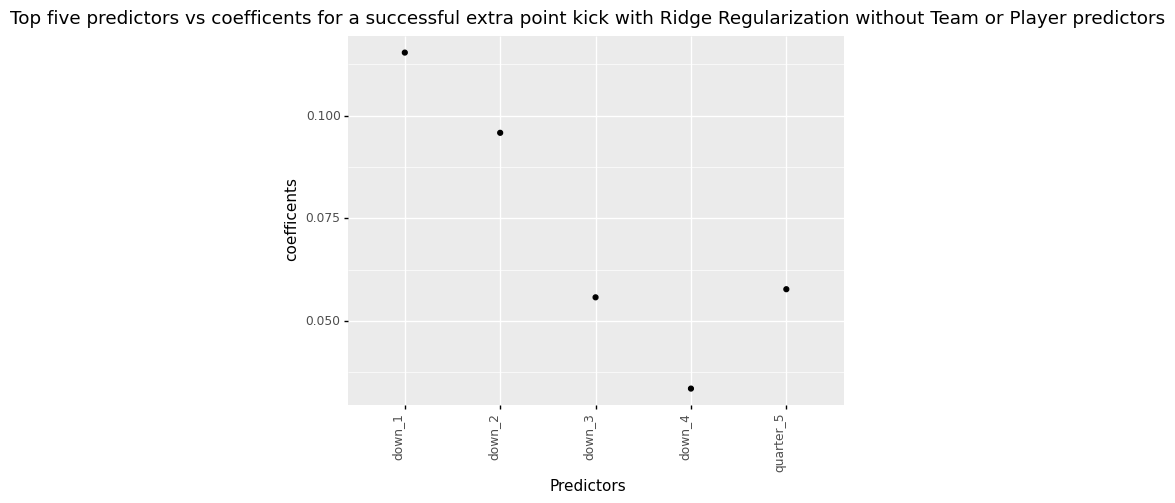

<ggplot: (402333904)>

In [20]:
(ggplot(ridge_nokickers_top5,aes(x='pred',y = 'coefs'))
 +geom_point()
 +theme(axis_text_x=element_text(rotation=90, hjust=1))
 +labs(title = "Top five predictors vs coefficents for a successful extra point kick with Ridge Regularization without Team or Player predictors")
 +xlab('Predictors')
 +ylab('coefficents')
)

This graph is similar to the last one but this has some of the predictors removed. The player ids are removed along with predictors relating to teams because I think that those predictors are pretty obvious because the best kickers and the teams with the best kickers will always perform well. I wanted to know what types of other predictors are most effective at predicting the best rate of success for a kick. Here we can see that as the downs and the quarters have relatively high coefficents. Looking at the graph we can see that first down has a relatively high coefficent on predicting whether or not a kick is successful. As the downs go down, the coefficents go down. I think this might be because of the pressure of kicking on a fourth down compared to a first down, so they are more likely to make a successful kick on the first down rather than a fourth down.

In [21]:
ridge.fit(Xp_train,yp_train)
ridge_punt_coef = ridge.coef_
meancoef_punt = np.mean(ridge_punt_coef, axis = 1)
ridge_punt_df = pd.DataFrame({'pred':ridge.feature_names_in_, 'coefs':meancoef_punt, 'absvals':np.abs(meancoef_punt)})
ridge_punt_df.sort_values(by=['absvals'], inplace=True, ascending = False)
ridge_punt_top5 = ridge_punt_df.head()
ridge_punt_top5

,pred,coefs,absvals
92,kickerId_52656.0,0.010407,0.010407
87,kickerId_47953.0,0.010073,0.010073
55,kickerId_38691.0,0.009625,0.009625
43,kickerId_25326.0,0.009168,0.009168
11,possessionTeam_ATL,0.009076,0.009076


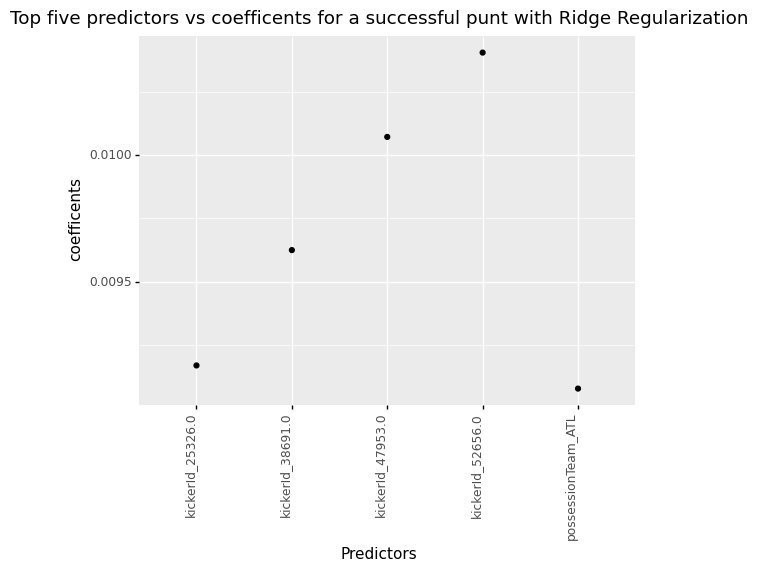

<ggplot: (402368904)>

In [22]:
(ggplot(ridge_punt_top5,aes(x='pred',y = 'coefs'))
 +geom_point()
 +theme(axis_text_x=element_text(rotation=90, hjust=1))
 +labs(title = "Top five predictors vs coefficents for a successful punt with Ridge Regularization")
 +xlab('Predictors')
 +ylab('coefficents')
)

Surprisingly in the punt coefficents we can see that the kickers height is the most important relationship to a successful punt. This is unexpected but also understandable. It seems that the consensus is that long legs does give you more force to kick it far distances but this isn't a strong correlation because it isn't unheard of that short kickers perform well. It would be interesting to see why this showed up this way with a deeper dive into the data. I also think that since the coefficents are so small its a negligable correlation with a successful punt and mostly due to more tall players being scouted and in the league. It's important to remember that all these are correlations and have a chance to not be causations.

<H2>Question 2</H2>

In [23]:
pred2 = ['quarter',
 'down',
 'yardsToGo',
 'kickerId',
 'returnerId',
 'kickBlockerId',
 'yardlineNumber',
 'preSnapHomeScore',
 'preSnapVisitorScore',
 'kickLength',
 'height',
 'weight',
 'kickType',
 'kickDirectionIntended',
 'kickDirectionActual',
 'returnDirectionIntended',
 'returnDirectionActual',
 'tackler',
 'kickoffReturnFormation',
 'kickContactType']
contpred2 = ['yardsToGo',
 'yardlineNumber',
 'preSnapHomeScore',
 'preSnapVisitorScore',
 'kickLength',
 'height',
 'weight']
disc_vars2 = np.setdiff1d(np.array(pred2),np.array(contpred2))

 'specialTeamsResult',
Fair Catch

In [24]:
outcome2 = 'kickReturnYardage'

In [25]:
df2 = df1.loc[((df1['specialTeamsPlayType'] == 'Kickoff') | (df1['specialTeamsPlayType']  == 'Punt'))& (df1['specialTeamsResult'] == 'Fair Catch')]
X2 = df2[pred2]
y2 = df2[outcome2]

In [26]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y2,test_size = 0.2)
# one hot encode discrete variables
X2_train = pd.get_dummies(X2_train,columns=disc_vars2,drop_first=True, dummy_na = True)
X2_test = pd.get_dummies(X2_test,columns=disc_vars2,drop_first=True, dummy_na = True)

In [27]:
EM = GaussianMixture()
z = make_column_transformer((StandardScaler(), contpred2))
pipe = make_pipeline(z, EM)
print(pipe.get_params().keys())

dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'gaussianmixture', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__verbose_feature_names_out', 'columntransformer__standardscaler', 'columntransformer__standardscaler__copy', 'columntransformer__standardscaler__with_mean', 'columntransformer__standardscaler__with_std', 'gaussianmixture__covariance_type', 'gaussianmixture__init_params', 'gaussianmixture__max_iter', 'gaussianmixture__means_init', 'gaussianmixture__n_components', 'gaussianmixture__n_init', 'gaussianmixture__precisions_init', 'gaussianmixture__random_state', 'gaussianmixture__reg_covar', 'gaussianmixture__tol', 'gaussianmixture__verbose', 'gaussianmixture__verbose_interval', 'gaussianmixture__warm_start', 'gaussianmixture__weights_init'])


In [28]:
components = {"gaussianmixture__n_components": range(1,30)}
grid = GridSearchCV(pipe,components, scoring = "accuracy", cv = 5)
EMmod = grid.fit(X2_train, y2_train)

In [29]:
EMmod.best_estimator_.get_params()["gaussianmixture__n_components"]

1

In [40]:
EMmod.predict(X2_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0])

In [41]:
y2_test

218016   NaN
212716   NaN
218021   NaN
126836   NaN
126845   NaN
334121   NaN
334130   NaN
218019   NaN
334126   NaN
218029   NaN
218023   NaN
218012   NaN
126828   NaN
334134   NaN
126826   NaN
126842   NaN
212719   NaN
126839   NaN
181751   NaN
218018   NaN
218013   NaN
334129   NaN
218024   NaN
334140   NaN
126830   NaN
Name: kickReturnYardage, dtype: float64

While I was running this I found out that the column I was going to use as my predictor was empty. Unfortuanately I couldn't find a conclusion to the question I had.

<H2>Question 3</H2>

In [31]:
pred3 = ['quarter',
 'down',
 'yardsToGo',
 'kickerId',
 'yardlineNumber',
 'preSnapHomeScore',
 'preSnapVisitorScore',
 'height',
 'weight',
 'kickType',
 'kickContactType']
contpred3 = ['yardsToGo',
 'yardlineNumber',
 'preSnapHomeScore',
 'preSnapVisitorScore',
 'height',
 'weight']

disc_vars3 = np.setdiff1d(np.array(pred3),np.array(contpred3))

outcome3 = 'accurateKic

In [32]:
df3 = df1.loc[((df1['specialTeamsPlayType'] == 'Kickoff') | (df1['specialTeamsPlayType']  == 'Punt'))]
df3 = df3.assign(accurateKick=lambda x: x.kickDirectionActual == x.kickDirectionIntended)

In [33]:
df3.dropna(inplace = True, subset = ['accurateKick'])
X3 = df3[pred3]
y3 = df3[outcome3]

0          True
1          True
2         False
3          True
4         False
          ...  
537048     True
537049    False
537050     True
537051    False
537052     True
Name: accurateKick, Length: 165245, dtype: bool

In [34]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3,y3,test_size=0.2)

In [35]:
X3_train = pd.get_dummies(X3_train,columns=disc_vars3,drop_first=True, dummy_na = True)
X3_test = pd.get_dummies(X3_test,columns=disc_vars3,drop_first=True, dummy_na = True)

In [36]:
DT = DecisionTreeClassifier(max_depth = 5)
DT.fit(X3_train,y3_train)
DT.score(X3_test,y3_test)

0.9889255348119459

Here I used a Decision tree to fit a model to predict using the predictors to figure out which side of the field a kick will be landed on the field. The score says that there is an accuracy of 98.8% in predicting the direction of a kick using the predictors. The confusion matrix below shows what the distribution of predicting whether a ball lands where the kicker intended compared to the actual direction the ball landed in. The true label means that both the intended and actual kick location are the same as false is the opposite. Since the diagonal that goes from the top left to the bottom right is higher in frequency than the other numbers, we know that this model is fairly accurate. This model uses a max_depth of 5 which means that it uses 5 predictors to predict the direction the kick is going.

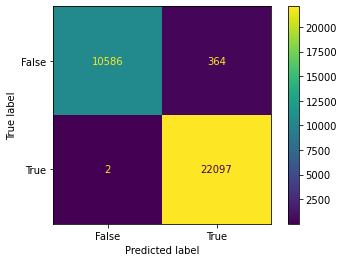

In [37]:
plot_confusion_matrix(DT, X3_test, y3_test)

In [38]:
text_representation = tree.export_text(DT)
print(text_representation)

|--- feature_32 <= 0.50
|   |--- feature_21 <= 0.50
|   |   |--- feature_58 <= 0.50
|   |   |   |--- feature_18 <= 0.50
|   |   |   |   |--- feature_20 <= 0.50
|   |   |   |   |   |--- class: True
|   |   |   |   |--- feature_20 >  0.50
|   |   |   |   |   |--- class: True
|   |   |   |--- feature_18 >  0.50
|   |   |   |   |--- feature_5 <= 188.00
|   |   |   |   |   |--- class: False
|   |   |   |   |--- feature_5 >  188.00
|   |   |   |   |   |--- class: True
|   |   |--- feature_58 >  0.50
|   |   |   |--- feature_11 <= 0.50
|   |   |   |   |--- feature_2 <= 13.50
|   |   |   |   |   |--- class: True
|   |   |   |   |--- feature_2 >  13.50
|   |   |   |   |   |--- class: True
|   |   |   |--- feature_11 >  0.50
|   |   |   |   |--- feature_1 <= 37.50
|   |   |   |   |   |--- class: True
|   |   |   |   |--- feature_1 >  37.50
|   |   |   |   |   |--- class: False
|   |--- feature_21 >  0.50
|   |   |--- feature_27 <= 0.50
|   |   |   |--- feature_58 <= 0.50
|   |   |   |   |--- fea

In [39]:
fig = plt.figure(figsize=(250,200))
plt.rc('font', size=20) #controls default text size
t = tree.plot_tree(DT, feature_names=DT.feature_names_in_, max_depth = 5)
plt.show()

Here is a visual depiction of the decision tree. (you can zoom into see the gini impurity which is the probablilty that a random point is classified incorrectly using the decision made through the node of a tree)